In [1]:
"""
Imports and global functions.
"""


from CommonUtilities import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
set_printoptions(suppress=True)


df = txt_to_pd("FileC017.txt")
events = df["TimeStamp[ms]"].astype(float).to_numpy() / 1000

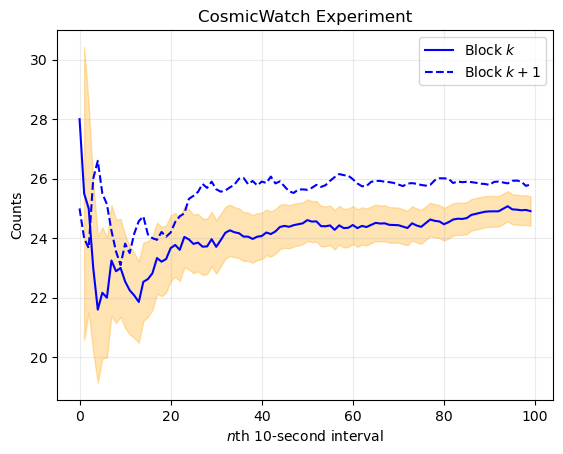

In [2]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Measuring the mean, part 2: plot the running average.
Measuring the mean, part 3: plot the error bars.
"""


# Extract 100 10-s bins and take statistics.
counts = bin_events(events, T=10) # T is the bin time.
N = 100 # Number of bins.
k = 0  # Which seris of N bins.
x, y_1 = arange(N), running_average(counts[k * N:(k + 1) * N])
x, y_2 = arange(N), running_average(counts[(k + 1) * N:(k + 2) * N])
sigma = std(counts[k * N:(k + 1) * N], ddof=1)

# Plot first 100, next 100, and error bar.
plt.plot(x, y_1,
         color='blue', label="Block $k$")
plt.plot(x, y_2,
         color='blue', linestyle="--", label="Block $k + 1$")
plt.fill_between(x[1:], y_1[1:] - sigma / sqrt(x[1:]), y_1[1:] + sigma / sqrt(x[1:]),
                 color='orange', alpha=0.3)
plt.grid(alpha=0.25)

# Cosmetics.
plt.title("CosmicWatch Experiment")
plt.xlabel('$n$th 10-second interval')
plt.ylabel('Counts')
plt.legend()
plt.show()

Average for first 100 10-s bins: 24.91.
Average for first 100 10-s bins: 25.81.
Error of first 100 10-s bins estimate: 0.4927955709495316.
Probability of a larger error 6.78%.


Text(0, 0.5, 'Number of Intervals')

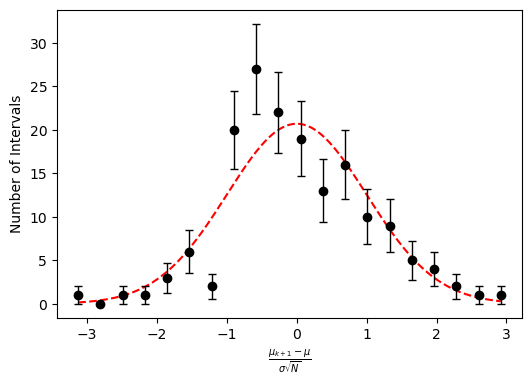

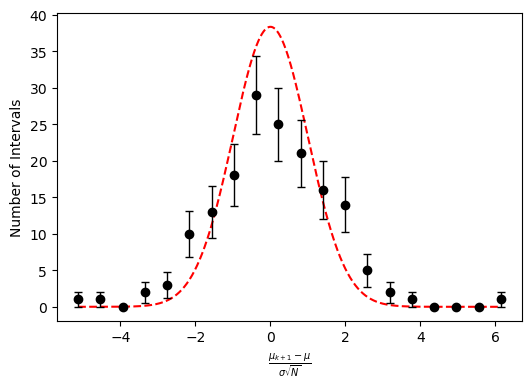

In [3]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Measuring the mean, part 4: reliability of estimated error bar.
"""

# Compare the first and second block of 100 intervals.
N = 100
avgs, stds = calc_block_stats(counts, N)
mu_0, mu_1 = avgs[0:2]
sigma_0 = stds[0] / sqrt(N)
p_larger = 200 * (1 - norm.cdf((mu_1 - mu_0) / sigma_0))
print(f"Average for first 100 10-s bins: {mu_0}.")
print(f"Average for first 100 10-s bins: {mu_1}.")
print(f"Error of first 100 10-s bins estimate: {sigma_0}.")
print(f"Probability of a larger error {p_larger:.2f}%.")

# Compare block average with average of ALL blocks.
errs = (avgs - average(avgs)) / std(avgs)
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

# Compare (k+1)th average with (k)th average and error estimate.
errs = (avgs[1:] - avgs[:-1]) / (stds[:-1] / sqrt(N))
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

10.223276855226503
0.9472212121509935


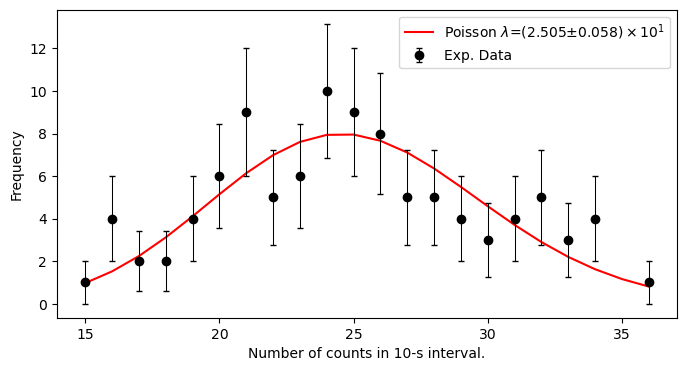

In [6]:
# Analysis parameters.
T = 10 # Interval time.
N = 100 # Number of intervals per block.
width = 1 # Histogram bin width.
cutoff = 0 # Drop bins with low rate (Poisson far from Gaussian)


# Histogram the number of muons per interval.
counts_anl = counts[k * N:(k + 1) * N]
counts = bin_events(events, T=T)
centers, freqs = integer_histogram(counts_anl, width=width)
centers, freqs = drop_zeros(centers, freqs)

# Fit Poisson distribution to experiment.
scale = N * width
fit = lambda n, n_avg: scale * poisson.pmf(n, n_avg)
poiss_args, poiss_stds, chi2, p_chi2 = fit_chi2(fit, [average(counts_anl)],
                                                centers, freqs, sqrt(freqs))
poiss_rpt = format_sigfigs(poiss_args, poiss_stds)
grid = arange(floor(centers)[0], ceil(centers)[-1] + 1)

# Plot data with error bars and compare to fit.
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(centers, freqs, yerr=sqrt(freqs), label="Exp. Data",
            fmt='o', c="k", capsize=2, elinewidth=0.75, zorder=10)
ax.plot(grid, fit(grid, *poiss_args),
        c="r", label=rf"Poisson $\lambda$={poiss_rpt[0]}")
ax.set_xlabel(f"Number of counts in {T}-s interval.")
ax.set_ylabel("Frequency")
ax.legend()

print(chi2)
print(p_chi2)

In [ ]:
poiss_stds

In [ ]:
block_chi2s = zeros(N_blocks)

for k in range(N_blocks):
    centers, freqs = integer_histogram(counts[k * N:(k + 1) * N], width=1)
    keep = where(freqs > 0)
    centers, freqs = centers[keep], freqs[keep]

    fit = lambda n, n_avg: N * width* poisson.pmf(n, n_avg)
    chi2 = calc_chi2(fit, [average(counts[k * N:(k + 1) * N])], centers, freqs, sqrt(freqs))
    ndof = len(centers) - 2
    block_chi2s[k] = calc_chi2_prob(chi2, ndof)

In [ ]:
plt.hist(calc_chi2_prob(random.chisquare(ndof, N_blocks), ndof))

In [ ]:
random.chisquare(30, size=100)

In [ ]:
poiss_args

In [ ]:
# NEW
def format_sigfigs(data: ndarray[float], stds: ndarray[float]) -> ndarray[str]:
    """
    Apply formating rules for significant figures, where we keep two sig figs
    of the error, e.g. 12.34 +/- 0.56.

    Params
    ------
    data: float ndarray
        Experimental data.
    stds: float ndarray
        Error (estimated standard deviation) of experimental data.

    Returns
    -------
    report: string ndarray
        Data and error written together in scientific notation with plus-minus
        notation and with correct significant figures.
    """

    report = []
    for d, s in zip(data, stds):
        l = int(floor(log10(abs(s))))
        r = rf"$({d / 10 ** l:.2f} ± {s / 10 ** l:.2f})$ $\times$ $10^{{{l}}}$"
        report.append(r)
    return array(report)

In [ ]:
int(round(1234.5678, -2))

In [ ]:
x = calc_chi2_prob(10 * linspace(0, 2, 100), 10)

In [ ]:
plt.plot(10 * linspace(0, 2, 100), x)

In [ ]:
calc_chi2_prob(16.176127257508885, len(centers) - 2)

In [ ]:
expected = N * width * poisson.pmf(centers[freqs > 0], average(counts[:N]))
sum((freqs[freqs > 0] - expected) ** 2 / freqs[freqs > 0])